# <div align="left"> <font color=blue>使用 TensorFlow Keras LSTM 预测正弦波形</font> </div>


此例原文出自以下链接，由于TensorFlow和Keras的升级有些代码需修改以后才能在新版本中使用 <br>
tensorflow version 1.2.1<br>
keras version 2.0.8 <br>

http://www.jakob-aungiers.com/articles/a/LSTM-Neural-Network-for-Time-Series-Prediction <br>
https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction

此例子主要使用 keras的 LSTM layer 预测正弦波，原始数据是预先生成的正弦波值，先用<font size=4>π</font>/50的间隔取样,将sin(弧度)计算后的值存成sinewave.csv文件。输入数据为(50,1)的原始数据，输出为下一个间隔为<font size=4>π</font>/50的值。

以下会分成两种不同的model
<font color=blue size=4>一种为有150个LSTM hidden unit + 1个Desne 全连接网络组成。</font><br>
<font color=blue size=4>另一种为三个LSTM 级联+ 1个Desne 全连接网络组成。 </font>


In [36]:
import numpy as np
import tensorflow as tf
import keras as ks
import matplotlib.pyplot as plt
import time;
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation,Input,Dropout
from keras.models import Model, load_model
from numpy import newaxis

global_start_time = time.time()
print("tensorflow version",tf.__version__)
print("keras version",ks.__version__)

tensorflow version 1.2.1
keras version 2.0.8


以下为读取数据，将原始数据从sinewave.csv中按50+1个读出，
取出前面的80%用做x_train,y_train，此部分需要使用np.random.shuffle(train)调整顺序
后面20%用做x_test,y_test,此部分数据，需保持顺序不变，因为需要做图方便验证

数据取出后使用 np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
将数据转换成 (batch_size,timesteps,inputdim)<br>
在此例中为  (3992,50,1) <br>
其中3992为80%的总数据 <br>
50为取50个间隔，也就是<font size=4>π</font>
由于此输入只有一个数值sin()的值，所以inputdim =1 <br>




具体关于Input部分可参见
https://stackoverflow.com/questions/45278286/how-to-choose-lstm-keras-parameters

<img src="inputdim.png"></img>



In [3]:
def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'rb').read()
    data = f.decode().split('\n')

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)

    row = round(0.8 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]


In [5]:
x_train,y_train,x_test,y_test =load_data("./sinwave.csv",50,1)

print("x_train.shape =",x_train.shape)
print("y_train.shape =",y_train.shape)
print("x_test.shape  =",x_test.shape)
print("y_test.shape  =",y_test.shape)


x_train.shape = (3960, 50, 1)
y_train.shape = (3960,)
x_test.shape  = (990, 50, 1)
y_test.shape  = (990,)


<font color=blue>以下部分为最后验证画图部分，如只为学习可以暂时略过</font>

In [33]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction '+str(i))
        plt.legend()
    plt.show()

此部分为定义model,如前所述，可定义成单个和级联的两个model

In [24]:
def build_model_single():  #单个LSTM
    
    X_input = Input(shape=(50,1))
    X = LSTM(150,return_sequences=False,name="lstm0")(X_input)
    #X = Dropout(0.2)(X)
    
    X = Dense(1,activation='linear',name="fc")(X)
    
    start = time.time()
    model=Model(inputs = X_input, outputs = X, name='lstm_single_sin')
    model.compile(loss='mean_squared_error', optimizer='Adagrad')
      
    print("> model_single Compilation Time : ", time.time() - start)
    return model

In [10]:
def build_model_concat():  #级联LSTM
    
    X_input = Input(shape=(50,1))
    X = LSTM(100,return_sequences=True,name="lstm0")(X_input)
    #X = Dropout(0.2)(X)
    
    X = LSTM(10,return_sequences=True,name="lstm1")(X)
    #X = Dropout(0.2)(X)

    X=LSTM(5,name="lstm2")(X)
    #X = Dropout(0.2)(X)

    X = Dense(1,activation='linear',name="fc")(X)
    
    start = time.time()
    model=Model(inputs = X_input, outputs = X, name='lstm_concat_sin')
    model.compile(loss='mean_squared_error', optimizer='Adagrad')
      
    print("> Compilation Time : ", time.time() - start)
    return model

In [11]:
print('> Compiling...')
model = build_model_concat()
#model = build_model_single()


> Compiling...
> Compilation Time :  0.025017738342285156


# <font color=red>mode.fit 训练</font>
此过程较长每个epochs在cpu上跑时为8s左右，可以修改batch_size查看不同的训练效果

In [15]:
model.fit(x_train,y_train,epochs=5, batch_size=256, verbose=1)

Epoch 1/5
3960/3960 [==============================] - 7s - loss: 2.5947e-05     
Epoch 2/5
3960/3960 [==============================] - 7s - loss: 2.3221e-05     
Epoch 3/5
3960/3960 [==============================] - 7s - loss: 2.1574e-05     
Epoch 4/5
3960/3960 [==============================] - 9s - loss: 1.9412e-05     
Epoch 5/5
3960/3960 [==============================] - 9s - loss: 1.6561e-05     


# <font color=red>predict图形1</font>
此过程花费时间在几分钟，请耐心等待

Training duration (s) :  11.432101249694824


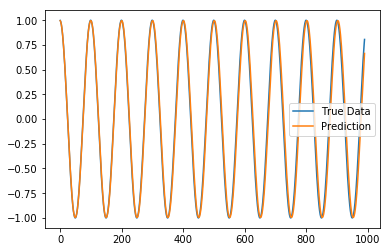

In [21]:
seq_len=50

start = time.time()
predicted = predict_sequence_full(model, x_test, seq_len)
print('Training duration (s) : ', time.time() - start)
plot_results(predicted, y_test)

# <font color=red>predict图形2</font>

Training duration (s) :  10.615524530410767


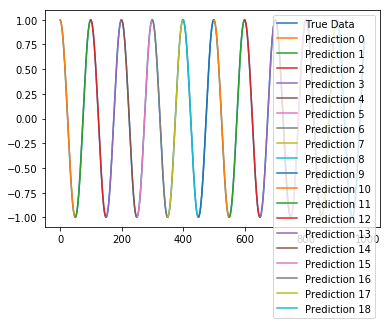

In [34]:
start = time.time()
predictions = predict_sequences_multiple(model, x_test, seq_len, 50)
print('Training duration (s) : ', time.time() - start)
plot_results_multiple(predictions, y_test, 50)